In [1]:
import tensorflow.keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [2]:
tweets = pd.read_csv('./training.csv', sep=',', encoding="latin-1", header=None,
                     names=['SentimentID', 'TweetID', 'DateTime', 'Something', 'Account', 'TweetText'])
tweets.head(5)

,SentimentID,TweetID,DateTime,Something,Account,TweetText
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
positive = 4
neutral = 2
negative = 0

data = tweets[['TweetText','SentimentID']]

data = data[data.SentimentID != neutral]
data['TweetText'] = data['TweetText'].apply(lambda x: x.lower())
data['TweetText'] = data['TweetText'].apply((lambda x: re.sub('(@[A-Za-z0-9]+)|(\w+:\/\/\S+)|([^a-zA-z0-9\s])','',x)))

print(data[ data['SentimentID'] == positive].shape[0])
print(data[ data['SentimentID'] == negative].shape[0])

800000
800000


In [5]:
max_features = 10000

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['TweetText'].values)
X = tokenizer.texts_to_sequences(data['TweetText'].values)
X = pad_sequences(X)

In [6]:
embed_dim = 256
lstm_out = 384

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 256)           2560000   
_________________________________________________________________
dropout (Dropout)            (None, 40, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 384)               984576    
_________________________________________________________________
dense (Dense)                (None, 2)                 770       
Total params: 3,545,346
Trainable params: 3,545,346
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
Y = pd.get_dummies(data['SentimentID']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1280000, 40) (1280000, 2)
(320000, 40) (320000, 2)


In [17]:
X_val = X_train[:20000]
Y_val = Y_train[:20000]

partial_X_train = X_train[20000:]
partial_Y_train = Y_train[20000:]

In [19]:
batch_size = 792

history = model.fit(partial_X_train, 
                    partial_Y_train, 
                    epochs = 3, 
                    batch_size=batch_size, 
                    validation_data=(X_val, Y_val))

Train on 1260000 samples, validate on 20000 samples
Epoch 1/3
1260000/1260000 [==============================] - 2705s 2ms/step - loss: 0.4223 - acc: 0.8051 - val_loss: 0.3970 - val_acc: 0.8194
Epoch 2/3
1260000/1260000 [==============================] - 2703s 2ms/step - loss: 0.3986 - acc: 0.8181 - val_loss: 0.3891 - val_acc: 0.8238
Epoch 3/3
1260000/1260000 [==============================] - 2716s 2ms/step - loss: 0.3871 - acc: 0.8240 - val_loss: 0.3841 - val_acc: 0.8263


In [20]:
import pickle
from tensorflow.keras.models import model_from_json

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")

print("Saved model to disk")

Saved model to disk


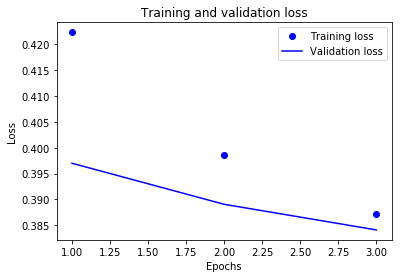

In [21]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

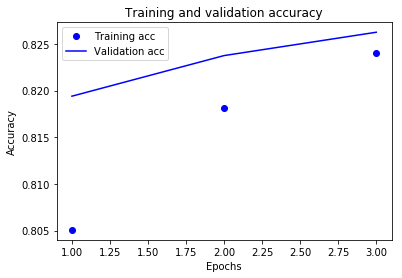

In [22]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_val)):
    result = model.predict(X_val[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
    if np.argmax(result) == np.argmax(Y_val[x]):
        if np.argmax(Y_val[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
    if np.argmax(Y_val[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 82.04359128174366 %
neg_acc 83.20664132826565 %
